In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt


In [3]:
#  File Paths

In [4]:

feature_path = "C:/Users/user/Desktop/main/AI_Smart_City/data/features"
model_path   = "C:/Users/user/Desktop/main/AI_Smart_City/models"
os.makedirs(model_path, exist_ok=True)

In [5]:
# Load Dataset

In [7]:


print(" Loading energy_features.csv...")
energy = pd.read_csv(os.path.join(feature_path, "energy_features.csv"))
print(" Dataset loaded successfully!")
print("Shape:", energy.shape)
print(energy.head())


 Loading energy_features.csv...
 Dataset loaded successfully!
Shape: (2049137, 27)
         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  2006-12-16  17:26:00                5.374                  0.498   233.29   
1  2006-12-16  17:27:00                5.388                  0.502   233.74   
2  2006-12-16  17:28:00                3.666                  0.528   235.68   
3  2006-12-16  17:29:00                3.520                  0.522   235.02   
4  2006-12-16  17:30:00                3.702                  0.520   235.09   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  hour  \
0              23.0             0.0             2.0            17.0     0   
1              23.0             0.0             1.0            17.0     0   
2              15.8             0.0             1.0            17.0     0   
3              15.0             0.0             2.0            17.0     0   
4              15.8             0.0             1.0

In [8]:
# Data Preprocessing

In [9]:

energy.columns = energy.columns.str.strip().str.lower()
energy = energy.fillna(method='ffill').fillna(method='bfill')

for col in energy.columns:
    if col not in ['date', 'time']:
        energy[col] = pd.to_numeric(energy[col], errors='coerce')


energy = energy.dropna()


target_col = None
for col in energy.columns:
    if 'global_active_power' in col:
        target_col = col
        break

if not target_col:
    raise ValueError(" Could not find target column (Global_active_power) in dataset!")

print(f" Target variable set to: {target_col}")

C:\Users\user\AppData\Local\Temp\ipykernel_21376\1334867793.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  energy = energy.fillna(method='ffill').fillna(method='bfill')


 Target variable set to: global_active_power


In [10]:
 # Feature Selection (Simplified for API)

In [12]:

base_features = [
    'global_reactive_power',
    'voltage',
    'global_intensity',
    'sub_metering_1',
    'sub_metering_2',
    'sub_metering_3'
]


missing = [f for f in base_features if f not in energy.columns]
if missing:
    raise ValueError(f"Missing columns in dataset: {missing}")


X = energy[base_features]
y = energy[target_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(" Train/Test split done")
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Using features: {base_features}")


 Train/Test split done
Train samples: 1639309, Test samples: 409828
Using features: ['global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']


In [13]:
# Model Training (XGBoost)

In [14]:

print("\n Training Energy Forecasting Model...")
xgb_energy = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

xgb_energy.fit(X_train, y_train)


 Training Energy Forecasting Model...


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [15]:
# Model Evaluation

In [16]:

y_pred = xgb_energy.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n Model Performance:")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")


 Model Performance:
RMSE : 0.032
R²   : 0.999


In [17]:
# Visualization

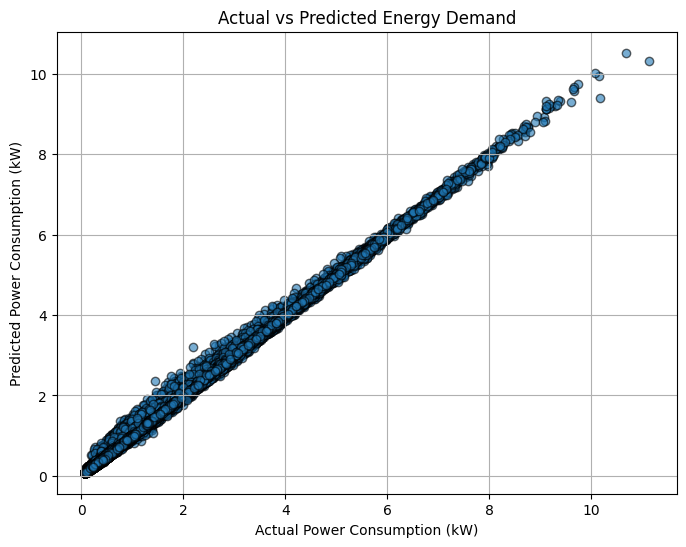

In [18]:

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.xlabel("Actual Power Consumption (kW)")
plt.ylabel("Predicted Power Consumption (kW)")
plt.title("Actual vs Predicted Energy Demand")
plt.grid(True)
plt.show()

In [19]:
#  SAVE MODEL & PREDICTIONS ---

In [20]:

model_file = os.path.join(model_path, "energy_model.pkl")

try:
    joblib.dump(xgb_energy, model_file)
    print(f" Model saved successfully → {model_file}")
except Exception as e:
    print(" Error while saving model:", e)

# Save predictions (for Power BI / Dashboard)
pred_df = pd.DataFrame({
    "Actual_Power": y_test,
    "Predicted_Power": y_pred
})
pred_file = os.path.join(model_path, "energy_predictions.csv")
pred_df.to_csv(pred_file, index=False)
print(f" Predictions saved → {pred_file}")

print("\n Energy Forecasting Model Training Completed Successfully!")

 Model saved successfully → C:/Users/user/Desktop/main/AI_Smart_City/models\energy_model.pkl
 Predictions saved → C:/Users/user/Desktop/main/AI_Smart_City/models\energy_predictions.csv

 Energy Forecasting Model Training Completed Successfully!
